In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import glob
import imageio
#from Functions import *
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
#from IPython.display import HTML
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib notebook
%matplotlib inline

## Camera Calibration
Images captured by a camera are typically distorted by the lens. In this step, I used the OpenCV functions findChessboardCorners and drawChessboardCorners to identify the locations of corners on a series of pictures of a chessboard taken from different angles. Next, the locations of the chessboard corners were used as input to the OpenCV function calibrateCamera to compute the camera calibration matrix and distortion coefficients. The matrix can then be used to undistort other images. Code for calibration is written in Camera Calibration Notebook.

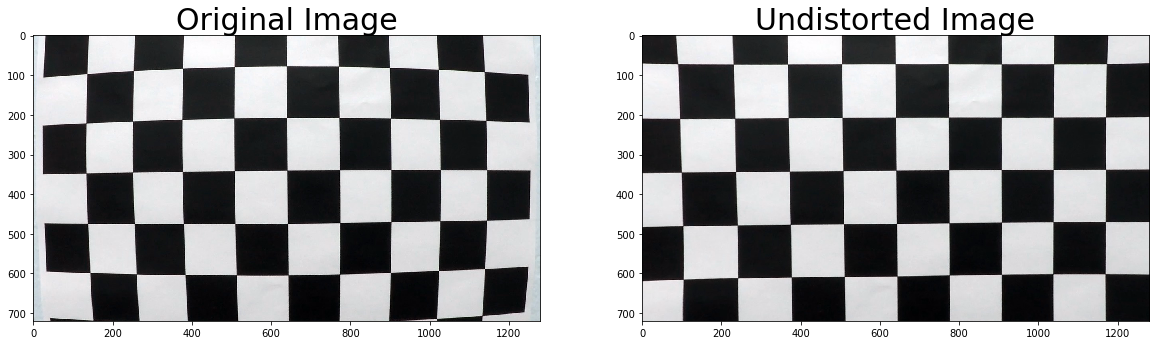

In [3]:
def img_undistort(img):
    # Unpickle calibrations, Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( "Undistorted_img/calibration_undistorted_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist= dist_pickle["dist"]
    #dist: Distortion coeifficient
    #mtx: Camera matrix need to transform 3d object points into 2d image points
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
#Visualize undistortion
img = cv2.imread('camera_cal/calibration1.jpg')
dst = img_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))# Read in the saved objpoints and imgpoints
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Binary Image
With CV2.imread images showing yellow lane line as blue coz CV2 reads as BGR With plt.imread got rid of this problem.

With RGB color space I was loosing yellow color information, so I tried HLS for image analysis and found S chanel detects lane line vary well.

HLS isolates Lightness component (L) which varies most under different lighting conditions
H & S components stay fairly consistent in shadow or excessive brightness.
After several trial and error with sobel at x direction, S and L channel finally I chose to create a combined binary threshold based on the L and B Channel only.

In [19]:
image = mpimg.imread('./test_images/test5.jpg')
image = img_undistort(image)
print(image.shape)
def combined_binary_mask(image, ksize, sat_low, sat_high, bright_low, bright_high, sx_low, sx_high, l_min, l_max):
    s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)[:,:,2]  
    
     # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x  , sobel_kernel=3
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_thresh=(20, 255)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_low) & (scaled_sobel <= sx_high)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sat_low) & (s_channel <= sat_high)] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= bright_low) & (b_channel <= bright_high)] = 1

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_min) & (l_channel <= l_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    binary = np.zeros_like(s_binary)
    binary[(l_binary == 1) | (b_binary == 1)] = 1
    #binary[((s_binary == 1) & (l_binary==1) | (b_binary == 1) | (sxbinary==1))] = 1
    return binary


(720, 1280, 3)


In [10]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

def interactive_mask(ksize, sat_low, sat_high, bright_low, bright_high, sx_low, sx_high, l_min, l_max):
    combined = combined_binary_mask(image, ksize, sat_low, sat_high, bright_low, bright_high, sx_low, sx_high, l_min, l_max)                                
#     plt.figure(figsize=(10,10))
#     plt.imshow(combined,cmap='gray')
    plt_show_gray(combined,'Image Thresholding')
    #plt.show()
    
interact(interactive_mask, ksize=(1,31,2), sat_low=(0,255),\
         sat_high=(0,255), bright_low=(0,255), bright_high=(0,255),\
         sx_low=(0,255), sx_high=(0,255), l_min=(0, 255), l_max=(0,255))      

<function __main__.interactive_mask>

In [20]:
# Create binary thresholded images to isolate lane line pixels
def thresholding(image):
    s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)[:,:,2]  
    
     # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x  , sobel_kernel=3
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_thresh=(20, 255)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    binary = np.zeros_like(s_binary)
    binary[(l_binary == 1) | (b_binary == 1)] = 1
    # binary[((l_binary == 1) | (b_binary == 1) | (sxbinary==1))] = 1
    #binary = 255*np.dstack((binary,binary,binary)).astype('uint8')  
 
    return binary

## Perspective Transform
A perspective transform to and from "bird's eye" perspective is done in a function called warp(). The warp() function takes as input an color image (img) and outputs warped image. The parameters src and dst of the transform are hardcoded in the function as follows.

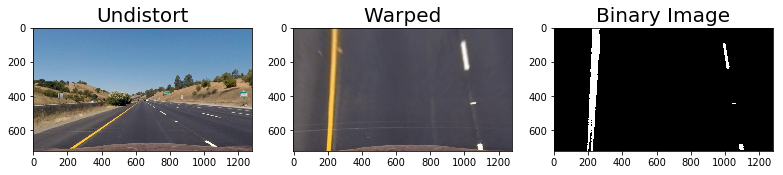

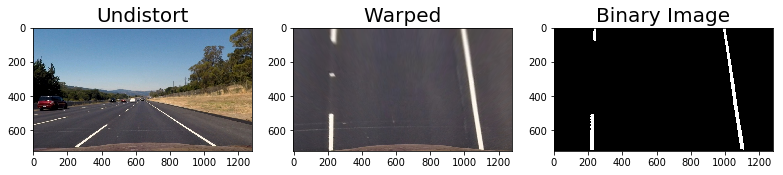

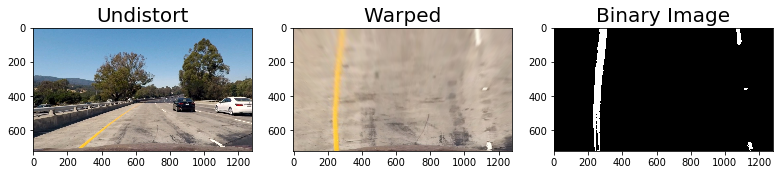

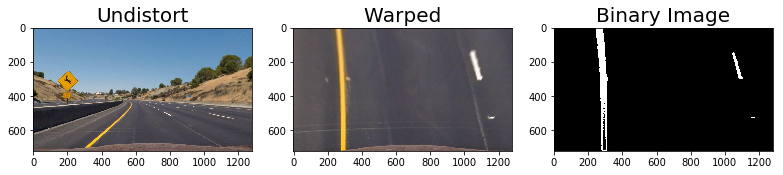

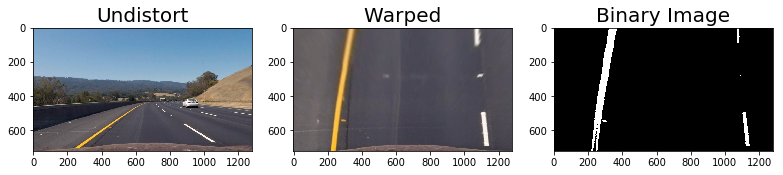

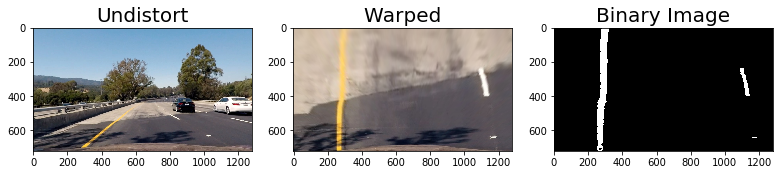

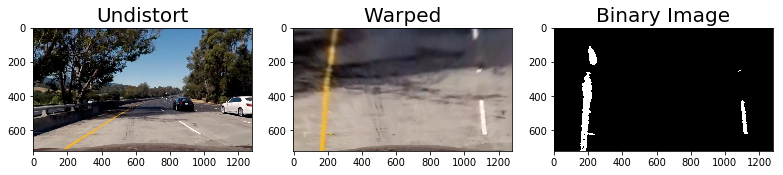

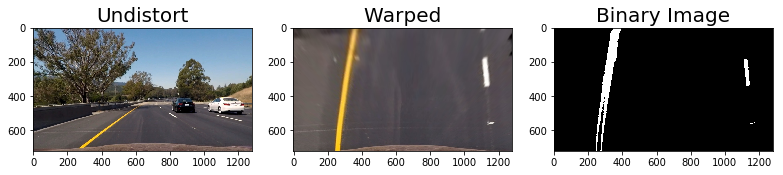

In [35]:
def warp(img):
    img=img_undistort(img)
    img_size = (img.shape[1], img.shape[0])
    offset = 200
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,Minv

images = os.listdir('./test_images') 
for fname in images:
    fname = os.path.join('test_images',fname)
    img = plt.imread(fname)
    undis = img_undistort(img)
    warped,Minv = warp(undis)
    warped_binary= thresholding(warped)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(undis, cmap='gray')
    ax1.set_title('Undistort', fontsize=20)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped', fontsize=20)
    ax3.imshow(warped_binary, cmap='gray')
    ax3.set_title('Binary Image', fontsize=20)

## Identifyed lane-line pixels and fit their positions with a polynomial
I was able to use the combined binary image to isolate only the pixels belonging to lane lines. The next step was to fit a polynomial to each lane line, which was done by:

1. Identifying peaks in a histogram of the image to determine location of lane lines.
2. Identifying all non zero pixels around histogram peaks using the numpy function numpy.nonzero().
3. Fitting a polynomial to each lane using the numpy function numpy.polyfit().
4. Calculated the average of the x intercepts from each of the two polynomials position = (rightx_int+leftx_int)/2
5. Calculated the distance from center by taking the absolute value of the vehicle position minus the halfway point along the horizontal axis distance_from_center = abs(image_width/2 - position)
6. Finally, the distance from center was converted from pixels to meters by multiplying the number of pixels by 3.7/700.

In [36]:
def sliding_window(img):
    undist = img_undistort(img)
    warped,Minv = warp(img)
    binary_warped= thresholding(warped)
# Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 35
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each and get A, B, C polinomial coefficients
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ###########################################
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #################
       # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty
 

## Tracking
After tuned pipeline on test images, I expanded my image pipeline to video pipeline to run on a video stream. 
The video pipeline first checks whether or not the lane was detected in the previous frame. If it was, then it only checks for lane pixels in close proximity to the polynomial calculated in the previous frame. The pipeline does not need to scan the entire image, and the lane pixels detected have a high confidence of belonging to the lane line because they are based on the location of the lane pixels in the previous frame.

If at any time, the pipeline fails to detect lane pixels based on the the previous frame, it will go back in to blind search mode and scan the entire binary image for nonzero pixels to represent the lanes.
In this case, however, you're going to keep track of things like where your last several detections of the lane lines were and what the curvature was, so you can properly treat new detections. 
This is done by defining a Line() class to keep track of all the interesting parameters function measure from frame to frame. 


In [37]:
from collections import deque
class Line:
    def __init__(self):
        # Was the line detected in the previous frame?
        self.found = False     
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None     
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)       
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None      
        # Remember radius of curvature
        self.radius = None      
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []      
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 600
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 30) < x)&(x < (xval + 30))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 600
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 30) < x)&(x < (peak + 30))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [38]:
def lanelines(img):
    undist = img_undistort(img)
    warped,Minv = warp(img)
    binary_warped= thresholding(warped)
# Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    y = np.array(nonzero[0])
    x = np.array(nonzero[1])
    
    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)
            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, binary_warped)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, binary_warped)
        
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2) 
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
     # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
    
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
    # Left-Right Lane Lines Points to stream on Image
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
    
    # Stack Lane Image on Acctual Image
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
     # Fille Left and Right lines with color
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
     # UnWarp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'Camera Position from center {}(Cm)'.format(int((distance_from_center)*100)), (95,70), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (200,150), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
   
    return result


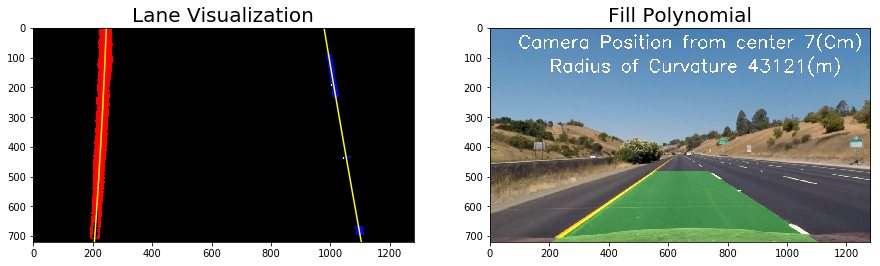

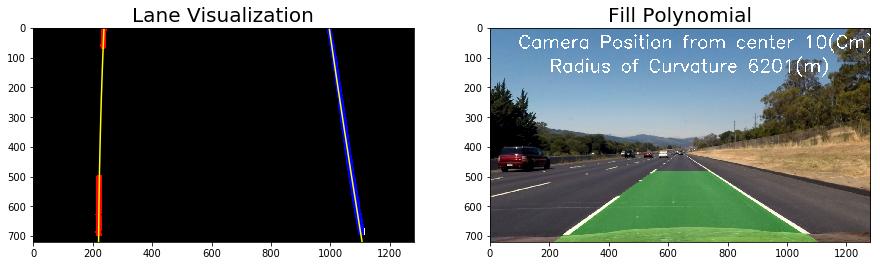

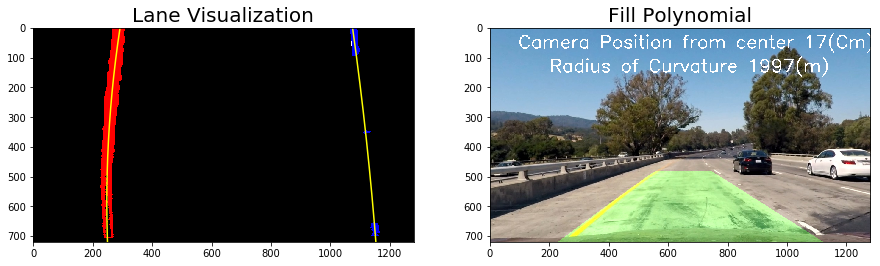

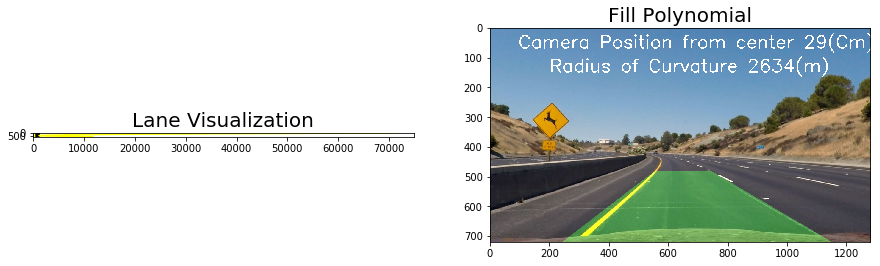

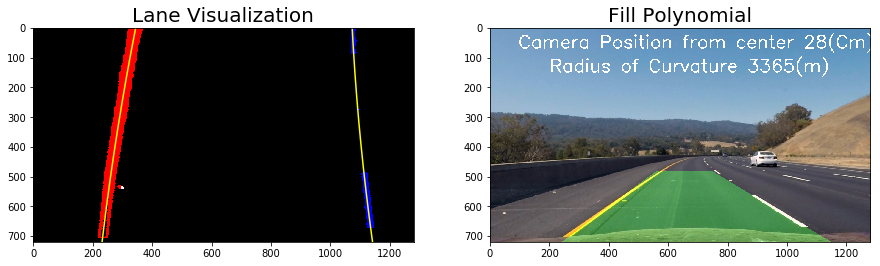

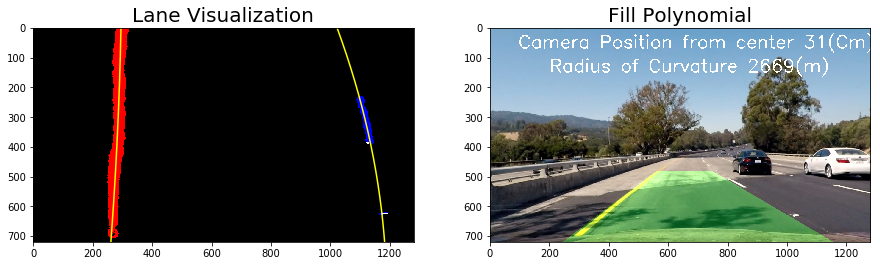

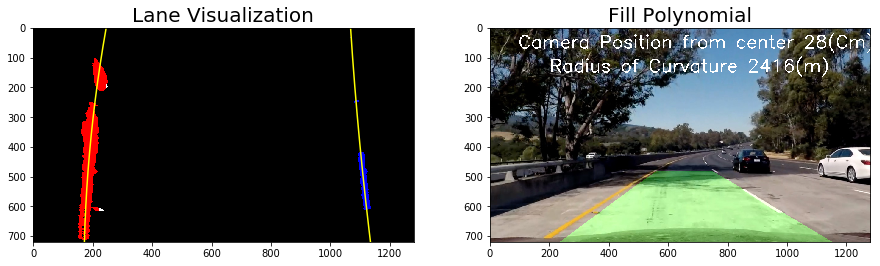

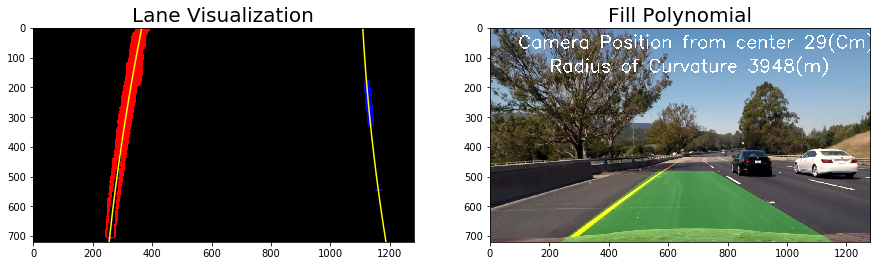

In [39]:
Left = Line()
Right = Line()
images = os.listdir('./test_images')  

for fname in images:
    fname = os.path.join('test_images',fname)
    img = plt.imread(fname)
    out_img, left_fitx, right_fitx, ploty = sliding_window(img)
        # Create an image to draw the lines on
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.imshow(out_img)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax1.set_title('Lane Visualization', fontsize=20)  
    ax2.imshow(lanelines(img))
    ax2.set_title('Fill Polynomial', fontsize=20)   

In [31]:
video_output = 'Project_Final_Video.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(3,8)
white_clip = clip1.fl_image(lanelines) #NOTE: this function expects color images!!
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video Project_Final_Video.mp4
[MoviePy] Writing video Project_Final_Video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:58<00:00,  5.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_Final_Video.mp4 



## Discussion
The video pipeline developed in this project did a fairly good job of detecting the lane lines in the test video, but not good on challenging video.
What I learned from this project is easy to fine tune parameters for know video. But I would like to know how my pipline would work on challenging conditions.
The system must accommodate a variety of roadways, a range of weather and lighting conditions, and highly dynamic scenes with other vehicles and moving objects.  The number of curves to estimate may be initially unknown and many of the observations may be outliers and false detections (e.g., due to tree shadows or lens flare). The challenge is to detect lanes when and where they exist, and to update the lane estimates as new observations are received.
For further deveopment I plan to keep improve my video pipeline and test it on challeging road conditions.

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('Advance_Lane_Final.mp4'))